In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import konlpy
from konlpy.tag import *
from matplotlib import font_manager, rc 
warnings.filterwarnings('ignore')

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import operator
import re

In [7]:
df = pd.read_csv("tweet_temp.csv", encoding="cp949", engine="python")
print(df.shape)
df.head()

(439, 2)


,created,tweet_text
0,20220307,"다이어리를 즐겨 쓰는데, 항상 글로만 남기는 게 아쉬웠던 찰나 친구랑 같이 놀러 갔..."
1,20210625,안녕하세요 소햰입니다! 오늘은 제가 말씀드린 코닥 미니샷 레트로3 리뷰입니다! 어...
2,20220119,안녕하세요 다꾸러 도뜨입니다. 전에 적어 두었던 포토프린트 추천 후기가 갑자기 에이...
3,20210116,"요즘 시국이 시국인지라.......집에서 주로 머물고 있는데, 그러다보니 아무래도 ..."
4,20220310,코닥 미니샷 레트로3! 몇 개월을 고민하고 비교해보다가 결정한 코닥미니샷3입니다! ...


In [8]:
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    return result

df['ko_text'] = df['tweet_text'].apply(lambda x: text_cleaning(x))
df.head()

,created,tweet_text,ko_text
0,20220307,"다이어리를 즐겨 쓰는데, 항상 글로만 남기는 게 아쉬웠던 찰나 친구랑 같이 놀러 갔...",다이어리를 즐겨 쓰는데 항상 글로만 남기는 게 아쉬웠던 찰나 친구랑 같이 놀러 갔다...
1,20210625,안녕하세요 소햰입니다! 오늘은 제가 말씀드린 코닥 미니샷 레트로3 리뷰입니다! 어...,안녕하세요 소햰입니다 오늘은 제가 말씀드린 코닥 미니샷 레트로 리뷰입니다 어제 출...
2,20220119,안녕하세요 다꾸러 도뜨입니다. 전에 적어 두었던 포토프린트 추천 후기가 갑자기 에이...,안녕하세요 다꾸러 도뜨입니다 전에 적어 두었던 포토프린트 추천 후기가 갑자기 에이서...
3,20210116,"요즘 시국이 시국인지라.......집에서 주로 머물고 있는데, 그러다보니 아무래도 ...",요즘 시국이 시국인지라집에서 주로 머물고 있는데 그러다보니 아무래도 이것저것 취미든...
4,20220310,코닥 미니샷 레트로3! 몇 개월을 고민하고 비교해보다가 결정한 코닥미니샷3입니다! ...,코닥 미니샷 레트로 몇 개월을 고민하고 비교해보다가 결정한 코닥미니샷입니다 사용한지...


In [9]:
# 한국어 처리 패키지 임포트
from konlpy.tag import Okt
from konlpy.tag import Hannanum
from collections import Counter

# 한국어 약식 불용어사전을 이용한 불용어 제거
korean_stopwords_path = "korean_stopwords.txt"
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

def get_nouns(x):
    nouns_tagger = Okt()
    nouns = nouns_tagger.nouns(x)
    # 한글자 키워드를 제거
    nouns = [noun for noun in nouns if len(noun) > 1]
    # 불용어를 제거
    nouns = [noun for noun in nouns if noun not in stopwords]
    return nouns

# ‘ko_text’ 피처에 이를 적용하여 키워드 추출하여 nouns컬럼에 저장
df['nouns'] = df['ko_text'].apply(lambda x: get_nouns(x))
print(df.shape)
df.head()

# 데이터 프레임에서 nouns컬럼만 남기고 모두 삭제
df.drop(columns=["created", "tweet_text", "ko_text"],inplace=True)

# 동시출현 단어쌍 (말뭉치) 도출
count = {}   #동시출현 빈도가 저장될 dict
for line in df['nouns']:
    #하나의 문서에서 동일한 단어가 두번 나와도 두번의 동시출현으로 고려X
    words = list(set(line))   
    #한줄씩 읽어와서 단어별로 분리(unique한 값으로 받아오기)
    #split은 띄어쓰기를 단어로 구분하라는 함수 
    
    for i, a in enumerate(words):
        for b in words[i+1:]:
            if a>b: 
                count[b, a] = count.get((b, a),0) + 1  
            else :
                count[a, b] = count.get((a, b),0) + 1

count.get(("a", "b"),0) #a, b라는 key가 없을 때는 디폴트를 0으로 해라 
count

#dictionary형 자료형을 판다스 데이터프레임으로 만들어줌 
#orient=index를 넣어야 행으로 쭉 나열이 됨 
df=pd.DataFrame.from_dict(count, orient='index')

list1=[]
for i in range(len(df)):
    #index를 중심으로 계속 중첩해서 list에 넣는다 
    list1.append([df.index[i][0],df.index[i][1],df[0][i]])

#pandas 이용해서 df형태로 만들기 
df2=pd.DataFrame(list1, columns=['word1','word2',"freq"])

#pandas 이용해서 sorting 하기 (디폴트가 오름차순이라서 false 꼭 써줘야 내림차순으로 나옴)
df3=df2.sort_values(by=['freq'],ascending=False)

#빈도 수 높은 순으로 말뭉치 10개만 가져오기
# df3=df3.head(30)

#데이터프레임 CSV형태로 저장
df3
df3.to_csv("networkx1.csv")

(439, 4)


In [2]:
import warnings
import konlpy
from konlpy.tag import *

from tqdm import tqdm_notebook
import platform
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as spst

from matplotlib import font_manager, rc 
warnings.filterwarnings('ignore')

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    rc("font", family="Arial Unicode MS")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family=font_name)
else:
    print("Unknown system. sorry")

In [32]:
name_values = df3["word1"].value_counts().index[:3]

In [17]:
df3 = df3[df3['word1']==name_values].reset_index(drop=True).head(30)

,word1,word2,freq
0,레트로,코닥,398
1,레트로,사진,394


In [11]:
dataset = dataset[dataset['word1']=='레트로'].reset_index(drop=True)
dataset

NameError: name 'dataset' is not defined

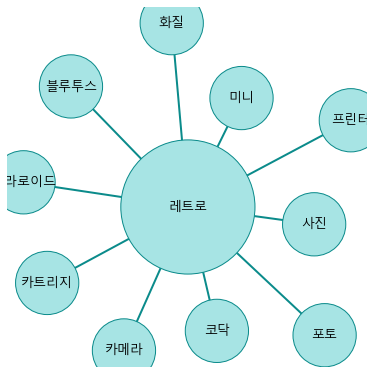

In [26]:
dataset = pd.read_csv("networkx1.csv")
dataset = dataset[dataset['word1']=='레트로'].reset_index(drop=True).head(10)
dataset

# 중심성 척도 계산을 위한 Graph를 만든다
G_centrality = nx.Graph()

# 빈도수가 높은 10개의 단어쌍에 대해서만 edge(간선)을 표현한다.
for ind in range((len(dataset))):
    G_centrality.add_edge(dataset['word1'][ind], dataset['word2'][ind], weight=int(dataset['freq'][ind]))

dgr = nx.degree_centrality(G_centrality)        # 연결 중심성
btw = nx.betweenness_centrality(G_centrality)   # 매개 중심성
cls = nx.closeness_centrality(G_centrality)     # 근접 중심성
egv = nx.eigenvector_centrality(G_centrality)   # 고유벡터 중심성
pgr = nx.pagerank(G_centrality)                 # 페이지 랭크

# 중심성이 큰 순서대로 정렬한다.
sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

# 단어 네트워크를 그려줄 Graph 선언
plt.figure(figsize=(5,5))
G = nx.Graph()

# 페이지 랭크에 따라 두 노드 사이의 연관성을 결정한다. (단어쌍의 연관성)
# 연결 중심성으로 계산한 척도에 따라 노드의 크기가 결정된다. (단어의 등장 빈도수)
for i in range(len(sorted_pgr)):
    G.add_node(sorted_pgr[i][0], nodesize=sorted_dgr[i][1])

for ind in range((len(dataset))):
    G.add_weighted_edges_from([(dataset['word1'][ind], dataset['word2'][ind], int(dataset['freq'][ind]))])

# 노드 크기 조정
# sizes = [G.nodes[node]['nodesize']*200 for node in G if G.nodes[node]['nodesize'] !=1.0]
# sizes = [G.nodes[node]['nodesize']*100 for node in G if G.nodes[node]['nodesize'] ==1.0]

for node in G:
    if G.nodes[node]['nodesize'] ==1.0:
        G.nodes[node]['nodesize'] = G.nodes[node]['nodesize'] * 180
    else:
        G.nodes[node]['nodesize'] = G.nodes[node]['nodesize'] * 400
sizes = [G.nodes[node]['nodesize'] * 100 for node in G]

options = {
    'node_color': '#A7E4E4',
    'edge_color': '#0B8B8B',
    'width': 2,
    'with_labels': True,
    'font_weight': 'regular',
    'font_size':13,
    'node_shape':"o",
}

# 폰트 설정을 위한 font_manager import
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt


nx.draw(G, node_size=sizes, pos=nx.spring_layout(G, k=30, iterations=1000), **options, font_family=font_name)  # font_family로 폰트 등록
ax = plt.gca()
ax.collections[0].set_edgecolor("#0B8B8B")

plt.savefig("1pi.jpg")
plt.show()

<AxesSubplot:xlabel='word2', ylabel='freq'>

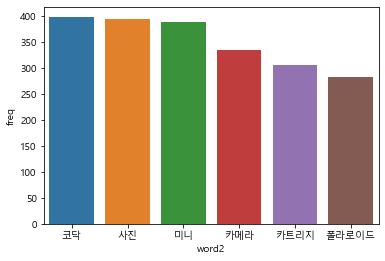

In [75]:
sns.barplot(data=dataset, x="word2",y="freq")